# transfer Learning with Tenssorflow Part 1 : Feature Extraction



In [ ]:
# Are we using gpu
!nvidia-smi

Sat Oct 21 16:15:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with data



In [6]:
# Get data (10% of 10 food classes from Food101)

import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the download file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2023-10-21 16:20:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.70.207, 74.125.132.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   180MB/s    in 0.9s    

2023-10-21 16:20:08 (180 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [9]:
# How many images in folder?
import os

# walk through our data
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f" There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

 There are 2 directories and 0 images in '10_food_classes_10_percent'.
 There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
 There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
 There are 0 directories and 75 images in '10_food_classe

## Create data loaders (preparing the Data)

we'll use the 'ImageDataGenerator' class to load in our image in batches.

In [28]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/225.)

print("Training Images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode= "categorical")


print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size= BATCH_SIZE,
                                               class_mode = "categorical")





Training Images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (Things to run whist our model trains)

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [22]:
# Create tensorboard callback ( functionized becaause we need to create a new one for each model)
import datetime

def create_tensorboard_calback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Createting models Using Tensorflow Hub

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page an sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [18]:
# Let's compaire the following two models

resnet_url= "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url= "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"





In [16]:
# Import dependancies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [23]:
# Let's make create_model() function to model from a url
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub URL and creates a keras sequential model with it.

  Args:
    model_url(str): A tensorflow hub feature extraction URL.
    num_classes (int): Number of output nrurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layers = hub.KerasLayer(model_url,
                                            trainable=False, # Freeze the already learned pattarens
                                            name= "feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)) # Freeze the already learned pattarens
  # cretae our own model
  model = tf.keras.Sequential([
      feature_extractor_layers,
      layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ])

  return model


## Creating and Testing ResNet Tensorflow hub feature extraction model

In [24]:
# Create resnet model

resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [20]:
train_data_10_percent.num_classes

10

In [25]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [26]:
# compile our model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [39]:
# Fit the model

restnet_history = resnet_model.fit(train_data_10_percent,
                                   epochs= 5,
                                   steps_per_epoch=len(train_data_10_percent),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[create_tensorboard_calback(dir_name="tensorflow_hub",
                                                                         experiment_name="restnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/restnet50V2/20231021-191303
Epoch 1/5
24/24 [==============================] - 11s 447ms/step - loss: 0.0809 - accuracy: 0.9987 - val_loss: 0.6254 - val_accuracy: 0.7924
Epoch 2/5
24/24 [==============================] - 11s 459ms/step - loss: 0.0731 - accuracy: 0.9973 - val_loss: 0.6227 - val_accuracy: 0.7900
Epoch 3/5
24/24 [==============================] - 11s 471ms/step - loss: 0.0665 - accuracy: 0.9987 - val_loss: 0.6255 - val_accuracy: 0.7932
Epoch 4/5
24/24 [==============================] - 14s 583ms/step - loss: 0.0616 - accuracy: 0.9987 - val_loss: 0.6242 - val_accuracy: 0.7920
Epoch 5/5
24/24 [==============================] - 11s 454ms/step - loss: 0.0562 - accuracy: 0.9987 - val_loss: 0.6273 - val_accuracy: 0.7912


In [40]:
# Plot loss curves (Create the function)

import matplotlib.pyplot as plt

#plot the validation and training curves

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History Object.

  Returns:
    Plot of training/validation loss and accuracy metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))


  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoches")
  plt.legend();

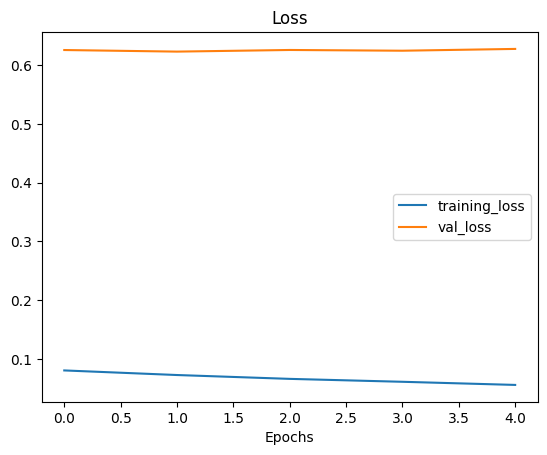

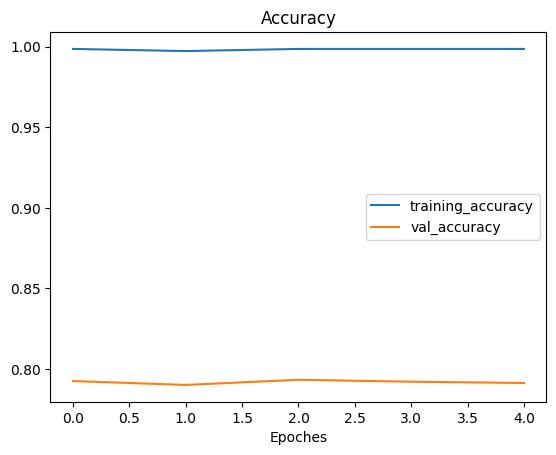

In [41]:
plot_loss_curves(restnet_history)

## Creating and Testing EfficientNetB0  Tensorflow hub feature extraction model

In [42]:
efficientnet_model = create_model(model_url= efficientnet_url,
                                  num_classes=10)

In [43]:
# compile Efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [47]:
#fit the model

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_calback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20231021-192503
Epoch 1/5
24/24 [==============================] - 22s 511ms/step - loss: 1.8655 - accuracy: 0.4573 - val_loss: 1.3073 - val_accuracy: 0.7236
Epoch 2/5
24/24 [==============================] - 10s 436ms/step - loss: 1.0538 - accuracy: 0.7853 - val_loss: 0.8862 - val_accuracy: 0.8068
Epoch 3/5
24/24 [==============================] - 10s 412ms/step - loss: 0.7526 - accuracy: 0.8467 - val_loss: 0.7151 - val_accuracy: 0.8276
Epoch 4/5
24/24 [==============================] - 10s 417ms/step - loss: 0.6063 - accuracy: 0.8707 - val_loss: 0.6287 - val_accuracy: 0.8460
Epoch 5/5
24/24 [==============================] - 12s 536ms/step - loss: 0.5148 - accuracy: 0.8893 - val_loss: 0.5769 - val_accuracy: 0.8540


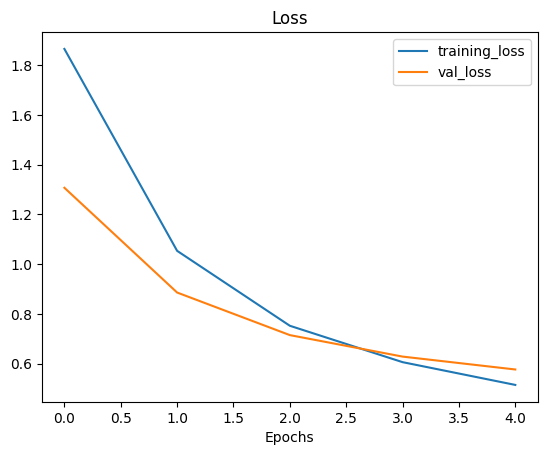

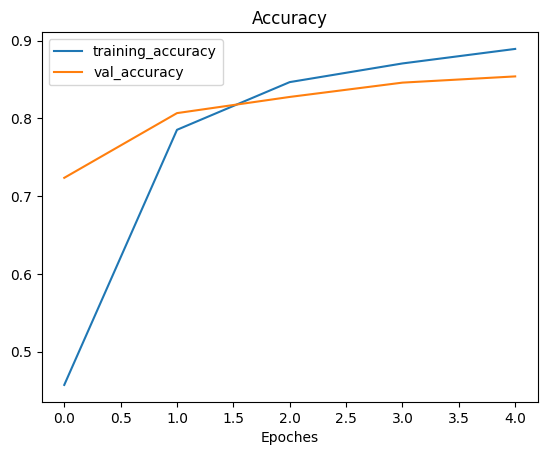

In [48]:
# Polot loss curve
plot_loss_curves(efficientnet_history)

In [49]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [50]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Diferent types of transfer learning

In [51]:
# How many layers does our efficientnetb0 feature extractor have?

efficientnet_model.layers

In [54]:
# efficientnet_model.layers[0].weights
len(efficientnet_model.layers[0].weights)

309

## Compairing our model results with tensorboard

In [56]:
 # Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB) vs ResNet50V2" \
  --description "Compairing two different TF Hub feature extractor model archicture using 10% of the training data"\
  --one_shot

2023-10-21 19:52:40.050522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   RZN-YVW-JRZ

RZN-YVW-JRZ


****************************************************************